# Seminar 2. Linear regression

**Main source:** https://github.com/esokolov/ml-course-hse/blob/master/2023-fall/seminars/sem02-sklearn-linregr.ipynb

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

# Введение в линейные модели

Напомним, что линейная регрессия &mdash; это модель следующего вида:
$$a(x) = \langle w, x \rangle + w_0$$
где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. Обучить линейную регрессию &mdash; значит найти $w$ и $w_0$.

В машинном обучении часто говорят об *обобщающей способности модели*, то есть о способности модели работать на новых, тестовых данных хорошо. Если модель будет идеально предсказывать выборку, на которой она обучалась, но при этом просто ее запомнит, не "вытащив" из данных никакой закономерности, от нее будет мало толку. Такую модель называют *переобученной*: она слишком подстроилась под обучающие примеры, не выявив никакой полезной закономерности, которая позволила бы ей совершать хорошие предсказания на данных, которые она ранее не видела.

Рассмотрим следующий пример, на котором будет хорошо видно, что значит переобучение модели. Для этого нам понадобится сгенерировать синтетические данные. Рассмотрим зависимость $y(x) = \cos(1.5\pi x)$, $y$ &mdash; целевая переменная, а $x$ - объект (просто число от 0 до 1). В жизни мы наблюдаем какое-то конечное количество пар объект-таргет, поэтому смоделируем это, взяв 30 случайных точек $x_i$ в отрезке $[0;1]$. Более того, в реальной жизни целевая переменная может быть зашумленной (измерения в жизни не всегда точны), смоделируем это, зашумив значение функции нормальным шумом: $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.01)$.

Попытаемся обучить три разных линейных модели: признаки для первой &mdash;  $\{x\}$, для второй &mdash; $\{x, x^2, x^3, x^4\}$, для третьей &mdash; $\{x, \dots, x^{20}\}$.

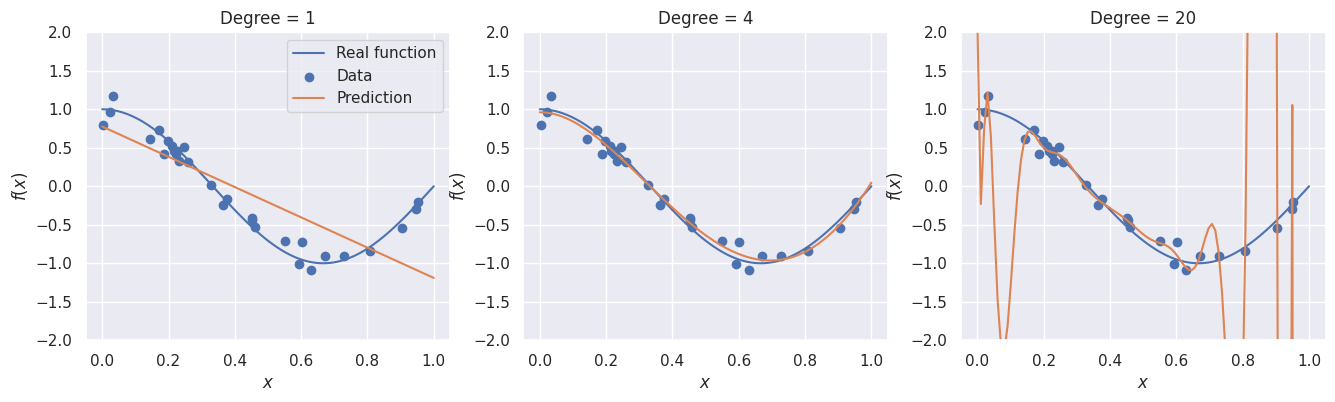

In [2]:
from sklearn.linear_model import LinearRegression

np.random.seed(36)
x = np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

from sklearn.preprocessing import PolynomialFeatures
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree, include_bias=False).fit_transform(x_objects[:, None])
    X = PolynomialFeatures(degree, include_bias=False).fit_transform(x[:, None])
    regr = LinearRegression().fit(X_objects, y_objects)
    y_pred = regr.predict(X)
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)

**Вопрос 1**: Почему первая модель получилась плохой, а третья переобучилась?

Чтобы избежать переобучения, модель регуляризуют. Обычно переобучения в линейных моделях связаны с большими весами, а поэтому модель часто штрафуют за большие значения весов, добавляя к функционалу качества, например, квадрат $\ell^2$-нормы вектора $w$:

$$Q_{reg}(X, y, a) = Q(X, y, a) + \lambda \|w\|_2^2$$

Это слагаемое называют $\ell_2$-регуляризатором, а коэффициент $\lambda$ &mdash; коэффициентом регуляризации. Более подробно о регуляризации и переобучении вы узнаете из лекций.

**Вопрос 2**: Почему большие веса в линейной модели &mdash; плохо?

**Вопрос 3**: Почему регуляризовать $w_0$ &mdash; плохая идея?

**Вопрос 4**: На что влияет коэффициент $\lambda$? Что будет происходить с моделью, если $\lambda$ начать уменьшать? Что будет, если $\lambda$ сделать слишком большим?

# Часть 1. Загружаем данные

Мы будем работать с данными из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), в котором требовалось предсказать стоимость жилья. Давайте сначала загрузим и немного изучим данные (можно взять `train.csv` со страницы соревнования и переименовать в `train_sem2.csv`).

In [3]:
!wget  -O 'train_sem2.csv' -q 'https://www.dropbox.com/s/6dxq90t0prn2vaw/_train_sem2.csv?dl=0'

In [4]:
data = pd.read_csv("train_sem2.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data.shape

(1460, 81)

In [6]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Первое, что стоит заметить &mdash; у нас в данных есть уникальное для каждого объекта поле id. Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

Разделим данные на обучающую и тестовую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это обычно стоит делать, она нужна для подбора гиперпараметров модели, то есть параметров, которые нельзя подбирать по обучающей выборке). Дополнительно нам придется отделить значения целевой переменной от данных.

In [7]:
from sklearn.model_selection import train_test_split

data = data.drop(columns=["Id"])

y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Посмотрим сначала на значения целевой переменной.

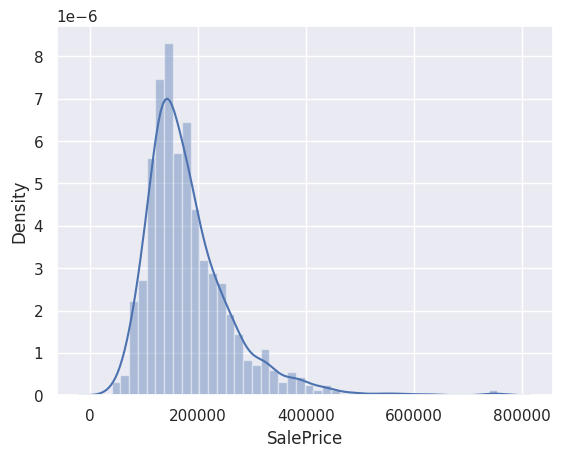

In [8]:
sns.distplot(y_train)
plt.show()

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам. В дальнейшем мы рассмотрим способы, как минимизировать ущерб от этого.

Так как для решения нашей задачи мы бы хотели обучить линейную регрессию, было бы хорошо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и целевой переменной. Корреляция Пирсона записывается следующим образом:

$$
\text{corr}(X, Y)=\frac{\operatorname{cov}_{X Y}}{\sigma_X \sigma_Y}=\frac{\sum_{i=1}^n(X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^n(X_i - \bar{X})^2 \sum_{i=1}^n(Y_i - \bar{Y})^2}}
$$

Заметим, что не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки.

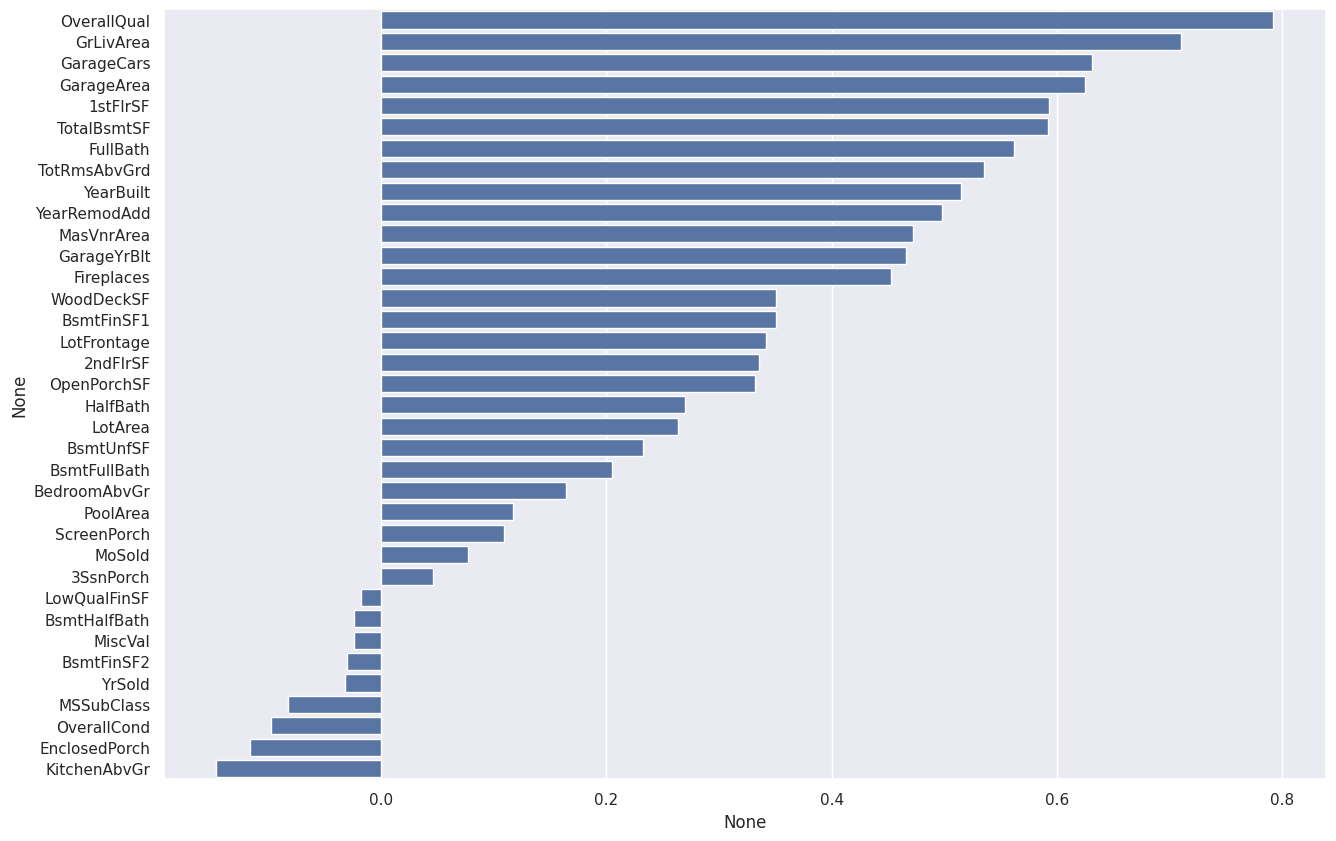

In [9]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет (такие графики называются scatter-plot).

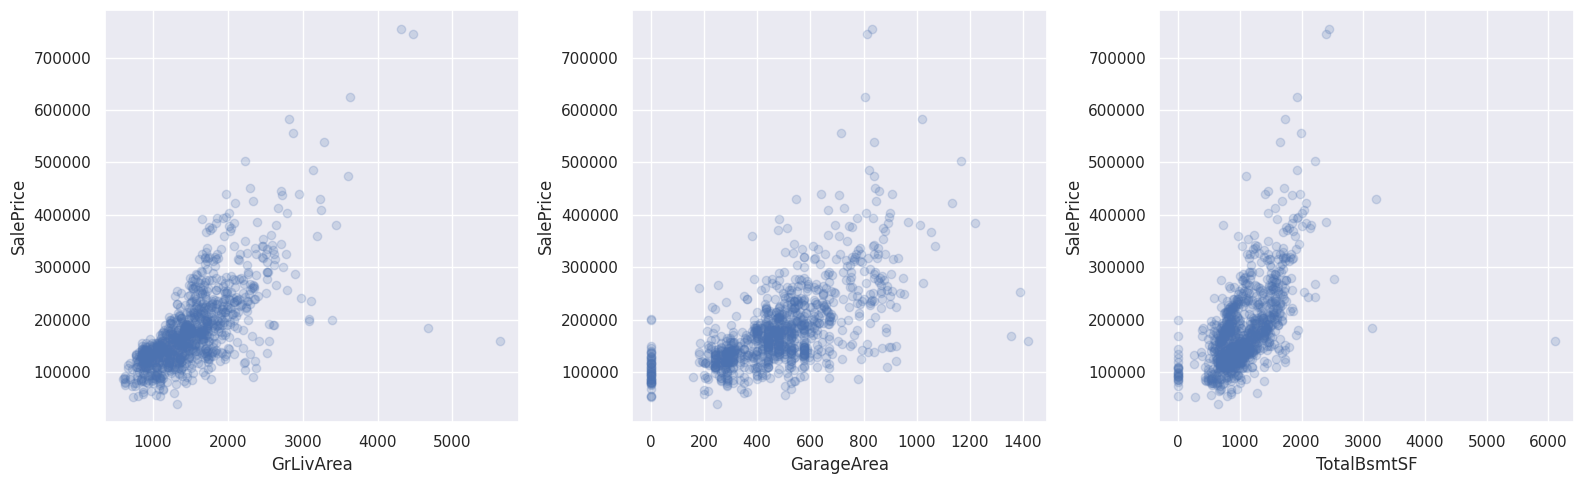

In [10]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

Видим, что между этими признаками и целевой переменной действительно наблюдается линейная зависимость.


# Модель

Попробуем обучить линейную регрессию на числовых признаках из нашего датасета. Для простых моделей (линейные модели, решающее дерево, ...) отлично подходит `sklearn`: в нем очень понятный и простой интерфейс. В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) &mdash; "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$
* [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией
* [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) &mdash; линейная регрессия с оптимизацией MSE и комбо $\ell_1$ и $\ell_2$-регуляризаций

У моделей из `sklearn` есть методы `fit` и `predict`. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке. Попробуем обучить нашу первую модель на числовых признаках, которые у нас сейчас есть:

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

model = LinearRegression()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print(f"Test RMSE = {mse(y_test, y_pred, squared=False):.2f}")
print(f"Train RMSE = {mse(y_train, y_train_pred, squared=False):.2f}")

Test RMSE = 32096.64
Train RMSE = 35631.16


Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации. Принцип кросс-валидации изображен на рисунке

<img src="https://camo.githubusercontent.com/83a61b58f2cce9e0762e7b5598b0002829fcaa5777ea0f75f3917454354552ee/68747470733a2f2f646f63732e73706c756e6b2e636f6d2f696d616765732f7468756d622f652f65652f4b666f6c645f63765f6469616772616d2e706e672f3132303070782d4b666f6c645f63765f6469616772616d2e706e67" width=50%>

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

In [12]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n", *cv_scores, "\n")
print(f"Mean CV MSE = {np.mean(-cv_scores):.2f}")

Cross validation scores:
	 
 -38812.23198998755 -45298.23474975181 -31401.35965784992 -33906.22799260072 -73842.38947487043 -24154.29779887909 -45535.146862931164 -52851.81381605851 -26127.90012003632 -29708.760291061706 

Mean CV MSE = 40163.84


Обратите внимание на то, что результаты `cv_scores` получились отрицательными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются `neg_*`, например, `neg_root_mean_squared_error`.

Обратите внимание, что по отложенной выборке и при кросс-валидации мы считаем RMSE (Root Mean Squared Error), хотя в функционале ошибки при обучении модели используется MSE.

$$\text{RMSE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (y_i - a(x_i))^2}$$

Если бы RMSE не входил в стандартные метрики `sklearn`, можно было бы его определить через функцию `sklearn.metrics.make_scorer`.

In [13]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False # то есть это функция потерь, которую хотим минимизировать
)

In [14]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n", *cv_scores, "\n")
print(f"Mean CV MSE = {np.mean(-cv_scores):.2f}")

Cross validation scores:
	 
 -38812.23198998755 -45298.23474975181 -31401.35965784992 -33906.22799260072 -73842.38947487043 -24154.29779887909 -45535.146862931164 -52851.81381605851 -26127.90012003632 -29708.760291061706 

Mean CV MSE = 40163.84


Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.

**Вопрос**: Чему равна оптимальная константа для RMSE?

In [ ]:
best_constant = #

print(f"Test RMSE with best constant = {}")
print(f"Train RMSE with best constant = {}")

SyntaxError: invalid syntax (<ipython-input-18-7ae47bfab0ee>, line 1)

Посмотрим на веса модели

In [21]:
def show_weights(features, weights, means, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=3)
    sorted_weights = sorted(zip(weights, features, means, scales), reverse=True)
    weights, features, means, scales = zip(*sorted_weights)
    features = list(features)

    sns.barplot(y=features, x=list(weights), ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=list(means), ax=axs[1])
    axs[1].set_xlabel("Mean")
    sns.barplot(y=features, x=list(scales), ax=axs[2])
    axs[2].set_xlabel("Scale")
    plt.tight_layout()

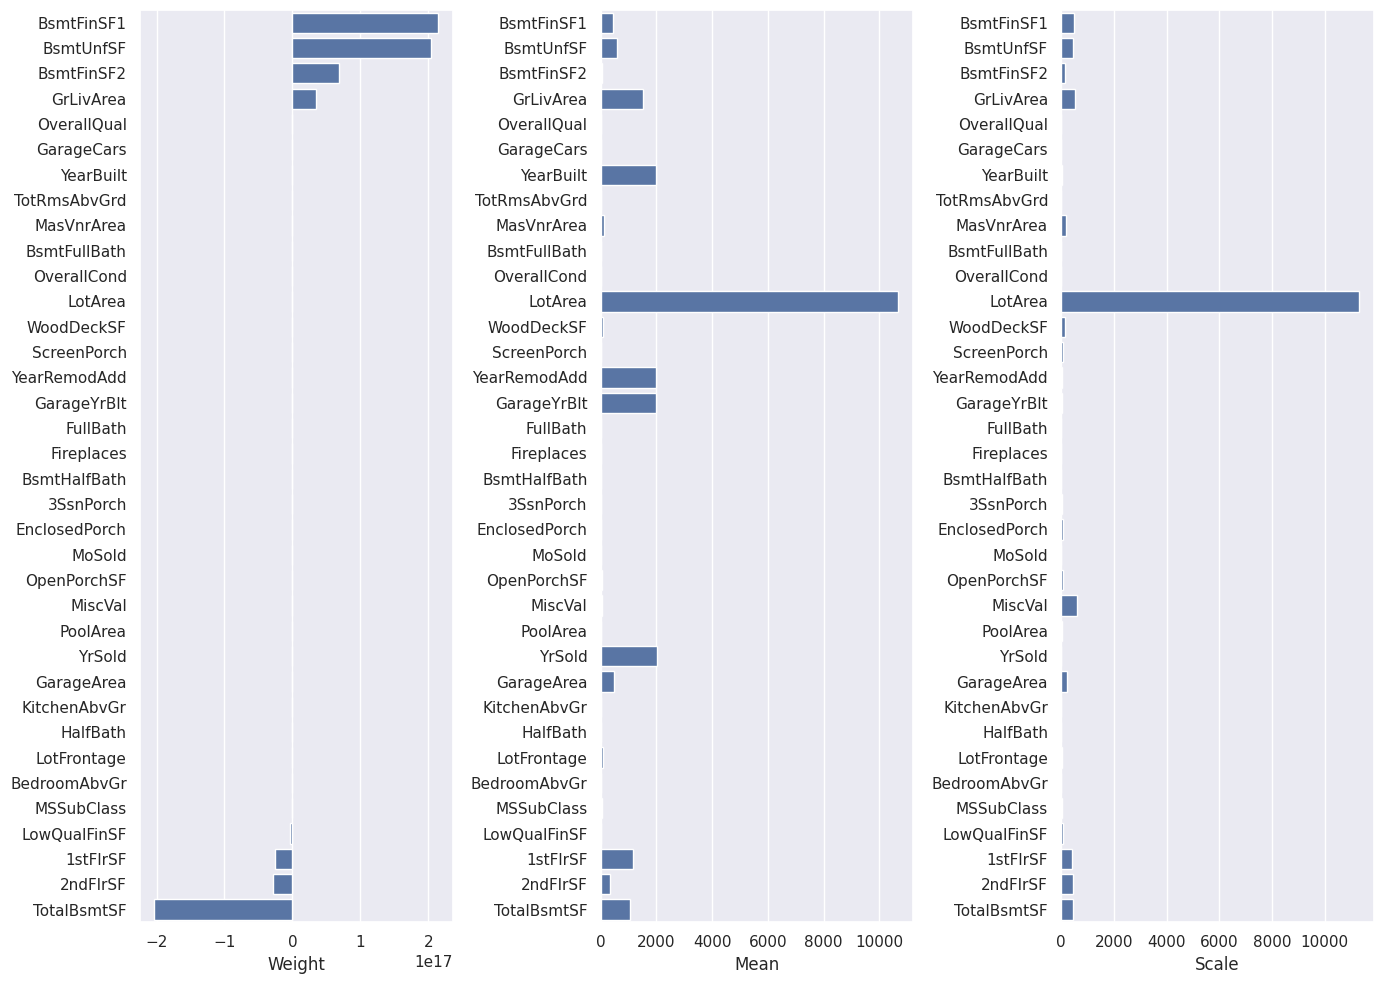

In [23]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].mean(), X_train[numeric_features].std())

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени.

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print(f"Test RMSE = {mse(y_test, y_pred, squared=False):.2f}")
print(f"Train RMSE = {mse(y_train, y_train_pred, squared=False):.2f}")

Test RMSE = 32125.47
Train RMSE = 35631.51


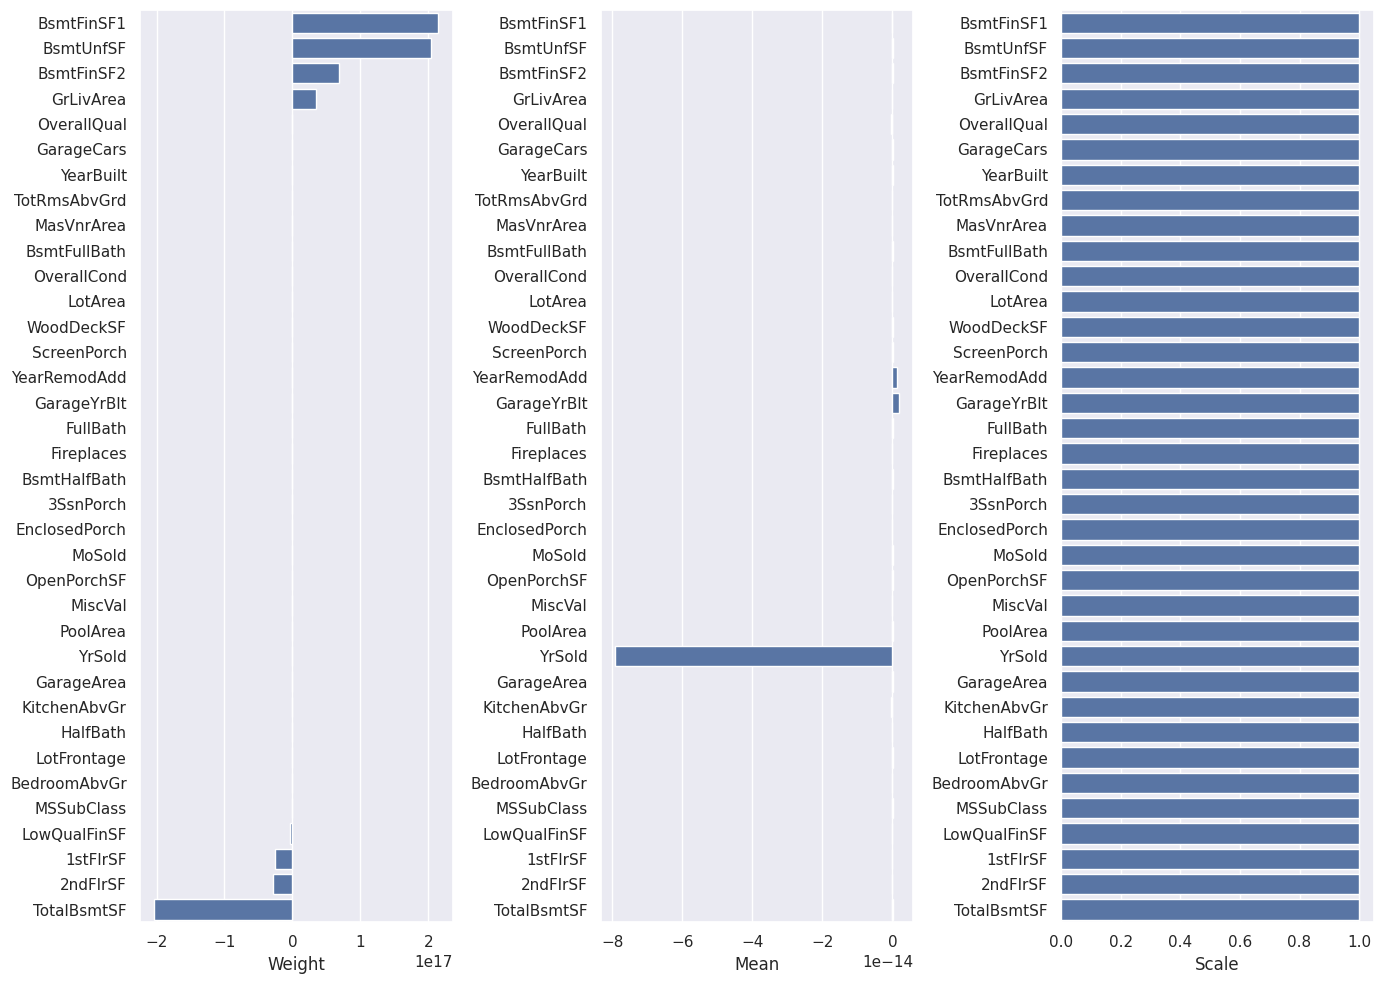

In [24]:
means = pd.Series(data=X_train_scaled.mean(axis=0), index=numeric_features)
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, means, scales)